In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
# 정규화 (0~1 사이)
transform = transforms.ToTensor()

# 데이터셋 다운운로드
train_dataset = datasets.MNIST(root='./data', train = True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train = False, download=True, transform=transform)

# DataLoader (배치단위)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),              # 입력 이미지를 1차원 벡터로 변환 (28x28 → 784)
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()

        )

        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()               # 출력값을 0~1 범위로 제한

        )

    def forward(self, x):
        x = self.encoder(x)                   # 입력 이미지를 잠재 벡터로 압축
        x = self.decoder(x)                   # 잠재 벡터를 다시 복원
        x = x.view(-1, 1, 28, 28)             # 1차원 벡터 → 2차원 이미지로 형태 재구성
        return x


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.0501
Epoch 2, Loss: 0.0223
Epoch 3, Loss: 0.0165
Epoch 4, Loss: 0.0137
Epoch 5, Loss: 0.0120
Epoch 6, Loss: 0.0110
Epoch 7, Loss: 0.0101
Epoch 8, Loss: 0.0093
Epoch 9, Loss: 0.0088
Epoch 10, Loss: 0.0083


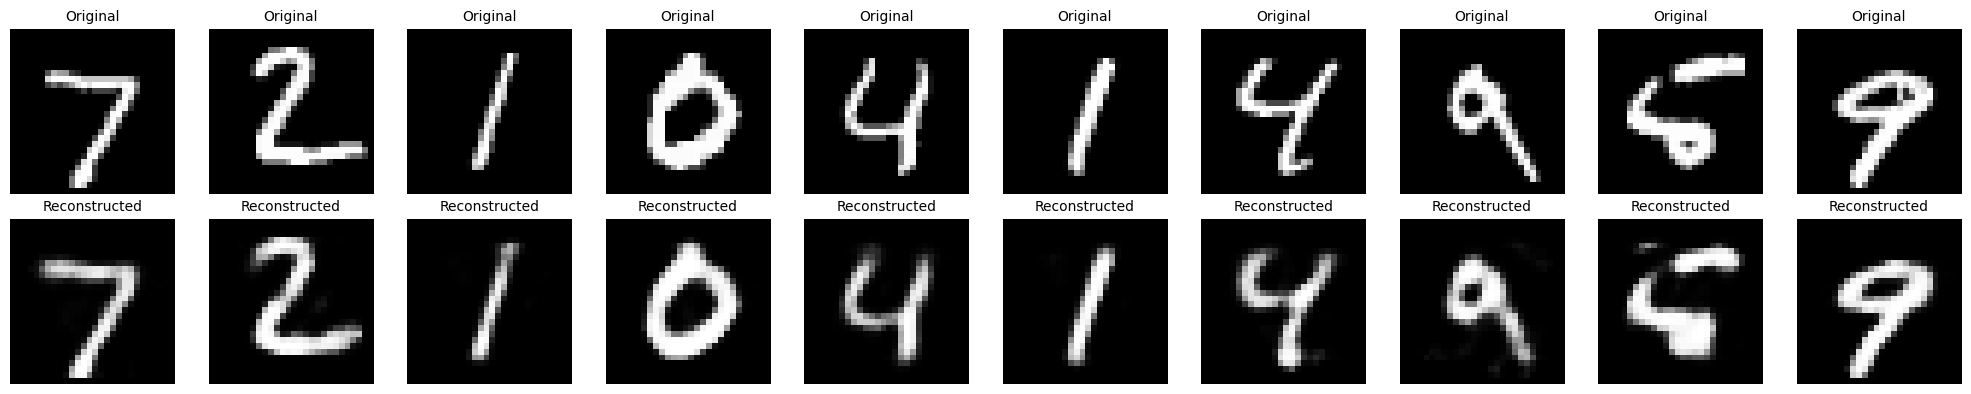

In [6]:
model.eval()
test_iter = iter(test_loader)
imgs, _ = next(test_iter)
imgs = imgs.to(device)
reconstructed = model(imgs)

# 시각화
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 이미지 (Original)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i].cpu().squeeze(), cmap='gray')
    ax.set_title("Original", fontsize=10)
    ax.axis('off')

    # 복원 이미지 (Reconstructed)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].cpu().squeeze().detach(), cmap='gray')
    ax.set_title("Reconstructed", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()
